In [1]:
import numpy as np # To perform numerical operations
import pandas as pd # To do data manipulation and analysis
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For advanced Data visualizations
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import train_test_split # For splitting dataset into training and testing set
from sklearn.linear_model import LinearRegression # For Model Selection
from sklearn.ensemble import RandomForestRegressor # Model Selection for Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # To Evaluate Model's Performance
from datetime import datetime  # To handle time based features 
import joblib # For saving and Loading the Trained Model



In [2]:
#Loading the plant 1 generation and Weather Sensor Data
generation_data = pd.read_csv('./data/Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('./data/Plant_1_Weather_Sensor_Data.csv')


generation_data.head(5) # viewing the first 5 rows of the Geneation dataset

# before merging the datasets we ne to convert date time format for proper time alignement

generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'], dayfirst=True) # Parsing the date string in the format of Day/month/year
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])


# Aggregating Generation Data
generation_agg = generation_data.groupby('DATE_TIME').agg({
    'DC_POWER':'sum', #calculating the sum of DC_Power
    'AC_POWER':'sum', #calculating the sum of AC_POWER
    'DAILY_YIELD' : 'mean', #calculating the average of DAILY_YEILD
    'TOTAL_YIELD' : 'mean' #calculating the average of TOTAL_YIELD
}).reset_index() # Used to control and manage the structure of a Dataframe's Index


# aggregating Weather Sensor Data
weather_agg = weather_data.groupby('DATE_TIME').agg({
    'AMBIENT_TEMPERATURE' : 'mean', #calculating average AMBIENT_TEMPERATURE
    'MODULE_TEMPERATURE' : 'mean', #calculating average MODULE_TEMPERATURE
    'IRRADIATION' : 'mean' #calculating average IRRADIATION
}).reset_index()


Final_Data = pd.merge(generation_agg,weather_agg,on='DATE_TIME',how='inner') #how carries other values like outer, left and right


C:\Users\ANAND REDDY\AppData\Local\Temp\ipykernel_22448\767172722.py:11: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])


In [3]:
Final_Data.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3157,3157.000000,3157.000000,3157.000000,3.157000e+03,3157.000000,3157.000000,3157.000000
mean,2020-06-01 06:41:41.298701568,68560.019625,6704.830534,3324.402716,6.977422e+06,25.560257,31.175453,0.230103
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.635010e+06,20.398505,18.140415,0.000000
25%,2020-05-23 23:15:00,0.000000,0.000000,4.124188,6.917337e+06,22.739895,21.130249,0.000000
50%,2020-06-01 12:30:00,8430.196429,814.880357,3009.619318,6.981686e+06,24.680324,24.801971,0.027748
75%,2020-06-09 18:00:00,140409.892856,13752.112500,6094.517045,7.045256e+06,27.941221,41.449481,0.451576
max,2020-06-17 23:45:00,298937.785710,29150.212499,8807.727273,7.097398e+06,35.252486,65.545714,1.221652
std,NaN,88055.843520,8604.217954,3045.292432,7.513782e+04,3.351059,12.272685,0.301348


In [4]:
# exploring null values
Final_Data.isnull().sum()

DATE_TIME              0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

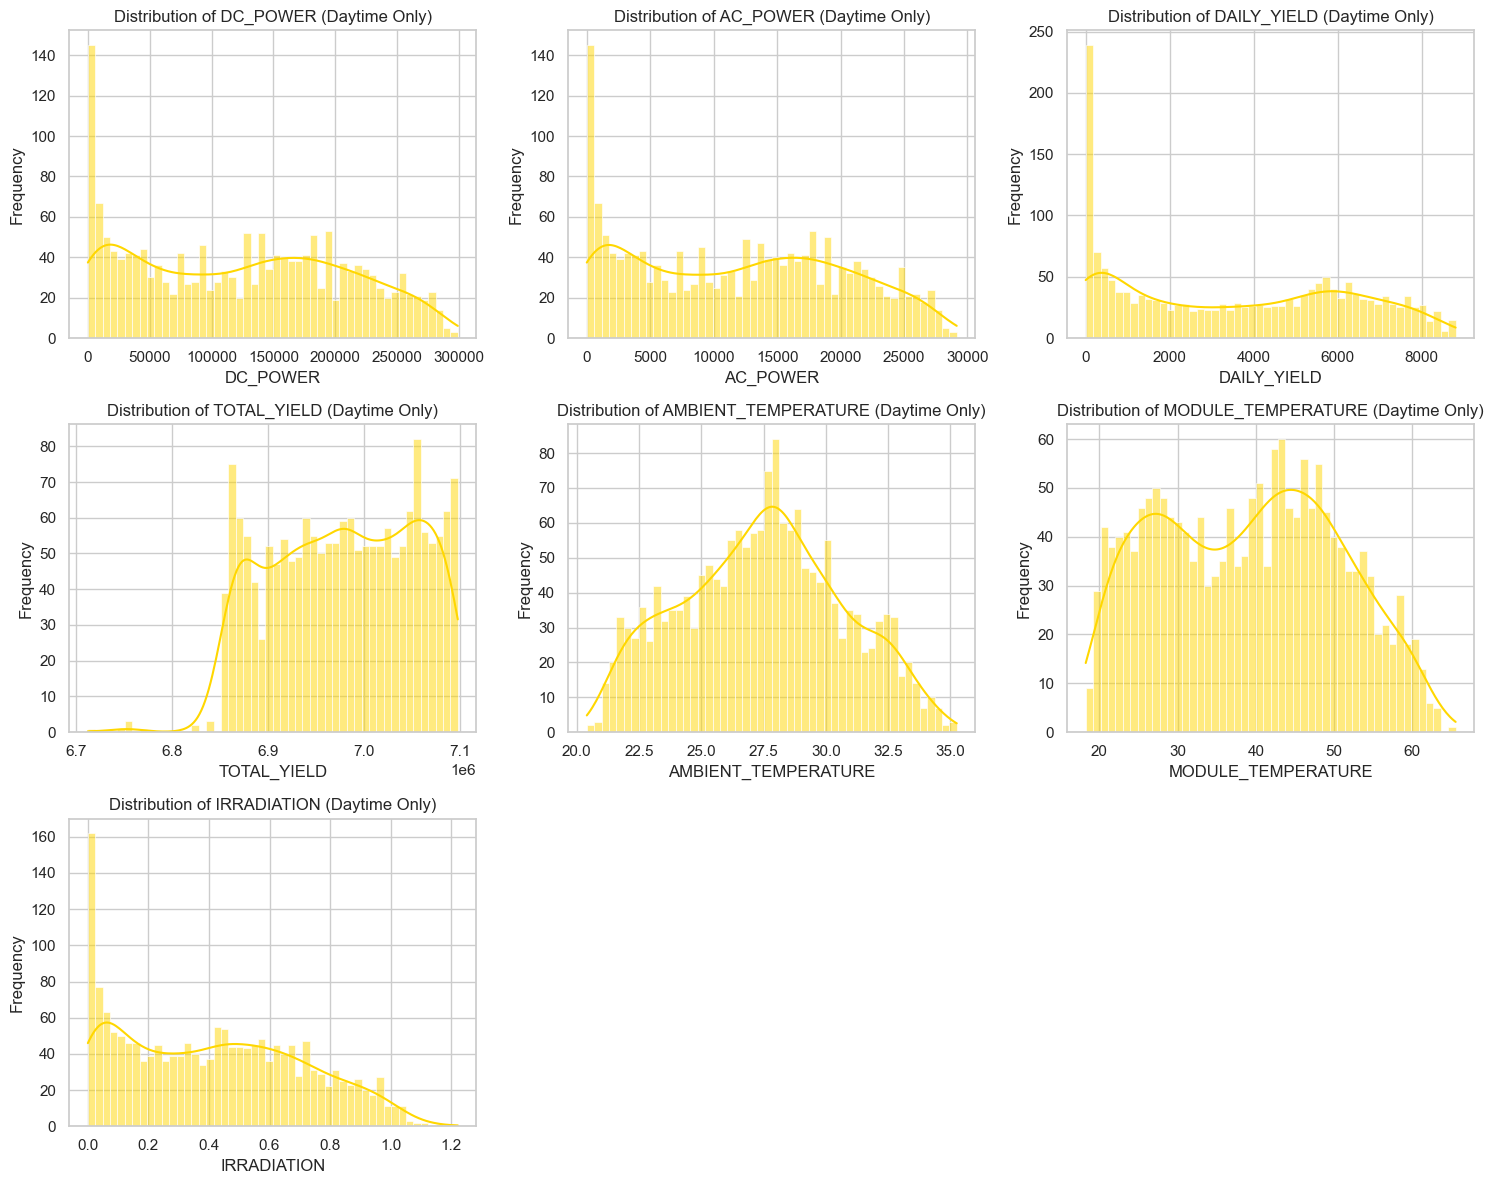

In [5]:
daytime_data = Final_Data[Final_Data['IRRADIATION']>0] # filtering only the day time data by setting Irridation > 0

numeric_columns = daytime_data.select_dtypes(include=['float64', 'int64']).columns # selecting only numeric columns from the dataframe

sns.set(style="whitegrid")

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(daytime_data[col], kde=True, bins=50, color='gold')
    plt.title(f'Distribution of {col} (Daytime Only)')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


**DC_POWER & AC_POWER** : Both show right-skewed distributions, indicating most readings are at lower power levels with fewer high-output instances.
* **DAILY_YEILD** : Right-skewed distribution suggests many days with lower energy production, potentially due to shorter daylight hours or cloudy weather conditions.
* **TOTAL_YEILD** : Displays a narrow range with a nearly uniform spread.
* **AMBIENT_TEMPERATURE** : Approximately normal distribution centered around 27–28°C.
* **MODULE_TEMPERATURE** : Bimodal distribution shows distinct heating patterns
* **IRRADIATION** : Strongly right-skewed, with a high frequency of low values.

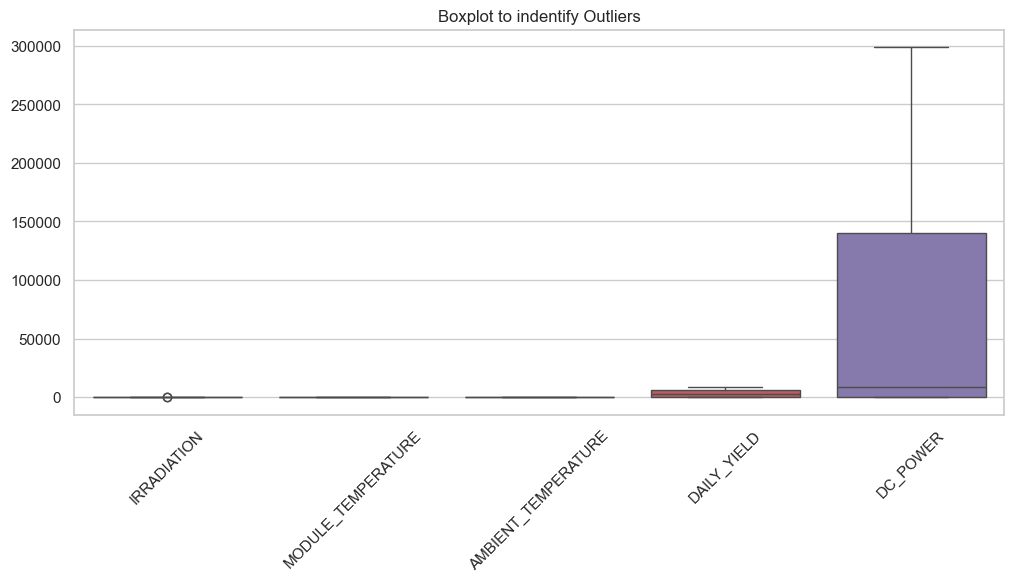

In [6]:

###outlier detection

# Using these features to visualize the box plot to identify the outliers in a dataframe
Features = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'DAILY_YIELD',
    'DC_POWER'
]
plt.figure(figsize=(12, 5))
sns.boxplot(data=Final_Data[Features])
plt.title("Boxplot to indentify Outliers")
plt.xticks(rotation=45)
plt.show()


# creating a copy to avoid the changes in original data
Data_Clean = Final_Data.copy()

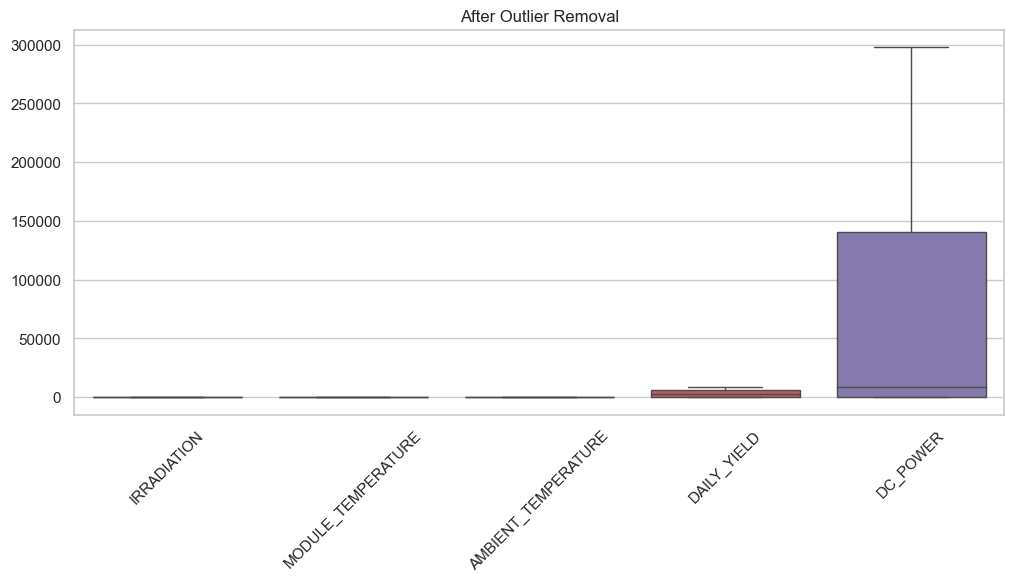

In [7]:
#applying IQR method to remove the outliers
for col in Features:
    Q1 = Data_Clean[col].quantile(0.25)
    Q3 = Data_Clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    Data_Clean = Data_Clean[(Data_Clean[col] >= lower_bound) & (Data_Clean[col] <= upper_bound)]

#Visualizing the box plot after removing the outliers
plt.figure(figsize=(12, 5))
sns.boxplot(data=Data_Clean[Features])
plt.title("After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

This updated box plot shows that most of the variables IRRADIATION, MODULE_TEMPERATURE, AMBIENT_TEMPERATURE, and DAILY_YIELD no longer have visible outliers. However AC_POWER still seems to have outliers, as indicated by data points extending beyond the whiskers. As we already applied IQR method to remove maximum of outliers from various features. Let's apply a time series chart for DC_POWER variable to check the data trends. This may help us to undertand whether these outliers are natural high values depending on the context of our dataset.


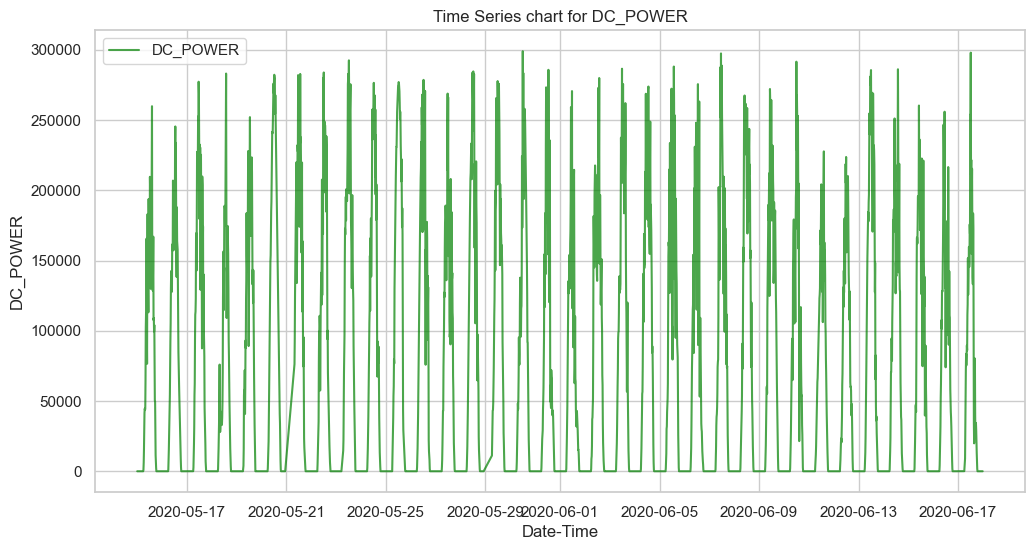

In [8]:
# Set DATE_TIME as the index
Final_Data.set_index('DATE_TIME', inplace=True)
Final_Data.sort_index(inplace=True)

# Plot DC_POWER time series
plt.figure(figsize=(12, 6))
plt.plot(Final_Data.index, Final_Data['DC_POWER'], color="green", alpha=0.7, label="DC_POWER")

plt.title("Time Series chart for DC_POWER")
plt.xlabel("Date-Time")
plt.ylabel("DC_POWER")
plt.legend()
plt.show()

In [9]:

features_to_scale = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'DAILY_YIELD',
    'DC_POWER',
    'AC_POWER' 
]
scaler = StandardScaler()
Final_Data_standardized = Final_Data.copy()
Final_Data_standardized[features_to_scale] = scaler.fit_transform(Final_Data[features_to_scale])

Final_Data_standardized.head()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,
2020-05-15 00:00:00,-0.77872,-0.779373,-1.091826,6.837223e+06,-0.112203,-0.677868,-0.763699
2020-05-15 00:15:00,-0.77872,-0.779373,-1.091826,6.837223e+06,-0.141968,-0.685679,-0.763699
2020-05-15 00:30:00,-0.77872,-0.779373,-1.091826,6.837223e+06,-0.186390,-0.699481,-0.763699
2020-05-15 00:45:00,-0.77872,-0.779373,-1.091826,6.837223e+06,-0.213138,-0.718343,-0.763699
2020-05-15 01:00:00,-0.77872,-0.779373,-1.091826,6.852802e+06,-0.280174,-0.734269,-0.763699


In [10]:
Final_Data_standardized.columns

Index(['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD',
       'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'],
      dtype='object')

In [11]:
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'] # Input features or Independant Features
target = 'DC_POWER' # Target Varibale or Dependent Variable

X = Final_Data_standardized[features]
y = Final_Data_standardized[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
y_pred = model.predict(X_test)
y_pred[:10]

array([-0.34450625, -0.77018957,  0.72458916,  0.87438323, -0.76650057,
       -0.76174483, -0.77116548, -0.76591571, -0.76259695,  1.56839787])

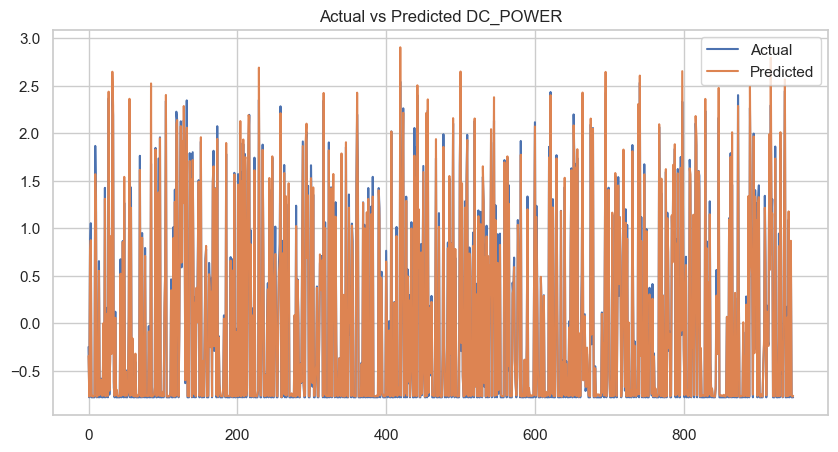

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted DC_POWER")
plt.legend()
plt.show()


In [19]:
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,y_pred)

In [20]:
print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"R2: {R2}")

MAE: 0.05148591493607389
MSE: 0.008098576821536035
RMSE: 0.08999209310565032
R2: 0.9919313632745048


In [32]:
# features used in model training
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']

# user input
user_input = []
print("Enter values for the following features:")

for feature in features:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Reshape to match scaler input
input_array = np.array(user_input).reshape(1, -1)

# Scale using a new scaler trained only on those 3 features
scaler = StandardScaler().fit(X_train)  
scaled_input = scaler.transform(input_array)

# Predict
predicted_power = model.predict(scaled_input)

print(f"\n⚡ Predicted DC Power: {predicted_power[0]:.4f}")

Enter values for the following features:

⚡ Predicted DC Power: 2.4834


d:\Edunet\EdunetEnv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\Edunet\EdunetEnv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [25]:
joblib.dump(model, 'solar_Power_eneration_model.pkl')
joblib.dump(scaler,"scaler.pkl")

['scaler.pkl']

In [31]:
import numpy as np
import pandas as pd
import joblib

# Features used in training
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']

# Get user input
user_input = []
print("Enter values for the following features:")
for feature in features:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Create DataFrame with feature names
input_df = pd.DataFrame([user_input], columns=features)

# Load scaler & model
scaler = joblib.load("scaler.pkl")
model = joblib.load("solar_Power_eneration_model.pkl")

# Scale input and keep DataFrame format
scaled_input = pd.DataFrame(
    scaler.transform(input_df),
    columns=features
)

# Predict
predicted_power = model.predict(scaled_input)

print(f"\n⚡ Predicted DC Power: {predicted_power[0]:.4f}")


Enter values for the following features:

⚡ Predicted DC Power: 2.4834
